In [1]:
from collections import Counter
import pandas as pd
import random
import spacy
from spacy.pipeline.textcat_multilabel import Config, multi_label_cnn_config
from spacy.training.example import Example
from spacy.util import minibatch, compounding


In [2]:
beers = pd.read_csv('./BeerDataScienceProject.csv', encoding ='latin1')
# get an idea of what the data looks like
print(beers.describe())
print(beers.columns)

            beer_ABV    beer_beerId  beer_brewerId  review_appearance  \
count  508590.000000  528870.000000  528870.000000      528870.000000   
mean        7.017442   22098.466016    2598.423429           3.864522   
std         2.204460   22158.284352    5281.805350           0.604010   
min         0.010000       3.000000       1.000000           0.000000   
25%         5.300000    1745.000000     132.000000           3.500000   
50%         6.500000   14368.000000     394.000000           4.000000   
75%         8.500000   40528.000000    1475.000000           4.000000   
max        57.700000   77310.000000   27980.000000           5.000000   

       review_palette  review_overall   review_taste   review_aroma  \
count   528870.000000   528870.000000  528870.000000  528870.000000   
mean         3.758926        3.833197       3.765993       3.817350   
std          0.685335        0.709962       0.669018       0.718903   
min          1.000000        0.000000       1.000000      

In [3]:
    # 1. Rank top 3 Breweries which produce the strongest beers?
    # 2. Which year did beers enjoy the highest ratings? 
    # 3. Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?
    # 4. If you were to recommend 3 beers to your friends based on this data which ones will you recommend?
    # 5. Which Beer style seems to be the favorite based on reviews written by users? 
    # 6. How does written review compare to overall review score for the beer styles?
    # 7. How do find similar beer drinkers by using written reviews only?       

In [4]:
    # 1. Rank top 3 Breweries which produce the strongest beers?

# remove duplicate beer listings (because of multiple reviews)
beers_groups_by_brewer = beers.drop_duplicates(['beer_brewerId', 'beer_name'],keep= 'last').groupby(['beer_brewerId'], axis=0).mean()
print(beers_groups_by_brewer.nlargest(3, 'beer_ABV')['beer_ABV'])

beer_brewerId
6513     24.690000
736      13.500000
24215    12.466667
Name: beer_ABV, dtype: float64


review_year
2000    3.909091
2010    3.897788
2012    3.896226
Name: review_appearance, dtype: float64
review_year
2000    3.939394
2010    3.798502
2012    3.797170
Name: review_palette, dtype: float64
review_year
2000    4.181818
1999    4.000000
2001    3.927741
Name: review_overall, dtype: float64
review_year
2000    3.984848
1999    3.820000
2010    3.808075
Name: review_taste, dtype: float64
review_year
2000    4.196970
1999    3.960000
1998    3.956522
Name: review_aroma, dtype: float64
review_year
1998    18.478261
1999    19.160000
2000    20.212121
2001    19.197674
2002    18.710724
2003    18.535960
2004    18.764680
2005    18.974145
2006    18.809484
2007    18.844133
2008    19.027533
2009    19.198282
2010    19.219763
2011    19.123182
2012    19.155975
Name: sum_column, dtype: float64


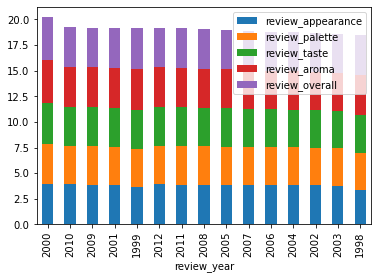

In [5]:
    # 2. Which year did beers enjoy the highest ratings? 
beers['review_year'] = pd.to_datetime(beers['review_time'], unit='s').dt.year
beers_groups_by_year = beers.groupby(['review_year'], axis=0).mean()
print(beers_groups_by_year.nlargest(3, 'review_appearance')['review_appearance'])
print(beers_groups_by_year.nlargest(3, 'review_palette')['review_palette'])
print(beers_groups_by_year.nlargest(3, 'review_overall')['review_overall'])
print(beers_groups_by_year.nlargest(3, 'review_taste')['review_taste'])
print(beers_groups_by_year.nlargest(3, 'review_aroma')['review_aroma'])

beers_groups_by_year = beers_groups_by_year[['review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'review_overall']]

# highest ratings = sum of all ratings, out of 25 total
beers_groups_by_year["sum_column"] = beers_groups_by_year.sum(1)
print(beers_groups_by_year['sum_column'])
beers_groups_by_year = beers_groups_by_year.sort_values("sum_column", ascending=False)
beers_groups_by_year = beers_groups_by_year.drop("sum_column", axis=1)

# graph that is sorted, with highest rankings first
ax = beers_groups_by_year.plot.bar(stacked=True)

In [6]:
nlp = spacy.load("en_core_web_sm")

def get_adjectives_and_nouns(review):
    adjs = set()
    nouns = set()
    for rev in review:
        if rev.pos_ == 'ADJ':
            adjs.add(rev.text.lower())
        if rev.pos_ == 'NOUN':
            nouns.add(rev.text.lower())
    return nouns, adjs

def get_reviews(reviws):
    review_nouns = Counter()
    review_adjs = Counter()
    for doc in reviews:
    # for review in reviews:
        if isinstance(doc, float):
            continue
        nlp_review = nlp(doc)
        nouns, adjs = get_adjectives_and_nouns(nlp_review)
        review_nouns.update(nouns)
        review_adjs.update(adjs)
        # print(adjs, nouns)
        # print(len(review_nouns), len(review_adjs))

    # print(review_nouns.most_common())
    # print(review_adjs.most_common())

    return review_nouns, review_adjs




In [7]:
    # 3. Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

    # check the adjectives and the nouns of the highest ratings in each category
    # then count with adjectives and nouns were most frequetly used
    # as those would be the most important factors

    reviews = beers[beers['review_taste'] > 4.5]['review_text']

    runs = 1000
    reviews = beers[beers['review_taste'] >= 4.5]['review_text'].head(runs)
    review_taste_nouns, review_taste_adjs = get_reviews(reviews)

    reviews = beers[beers['review_aroma'] >= 4.5]['review_text'].head(runs)
    review_aroma_nouns, review_aroma_adjs = get_reviews(reviews)

    reviews = beers[beers['review_appearance'] >= 4.5]['review_text'].head(runs)
    review_appearance_nouns, review_appearance_adjs = get_reviews(reviews)

    reviews = beers[beers['review_palette'] >= 4.5]['review_text'].head(runs)
    review_palette_nouns, review_palette_adjs = get_reviews(reviews)



In [8]:
# answers to question 3

print('review_taste_nouns', review_taste_nouns.most_common(20))
print('review_taste_adjs', review_taste_adjs.most_common(20))
print('review_aroma_nouns', review_aroma_nouns.most_common(20))
print('review_aroma_adjs', review_aroma_adjs.most_common(20))
print('review_appearance_nouns', review_appearance_nouns.most_common(20))
print('review_appearance_adjs', review_appearance_adjs.most_common(20))
print('review_palette_nouns', review_palette_nouns.most_common(20))
print('review_palette_adjs', review_palette_adjs.most_common(20))


review_taste_nouns [('head', 861), ('beer', 578), ('taste', 478), ('chocolate', 447), ('carbonation', 422), ('malt', 387), ('glass', 338), ('coffee', 327), ('flavor', 316), ('bit', 316), ('alcohol', 310), ('lacing', 309), ('finish', 309), ('hops', 284), ('aroma', 280), ('color', 273), ('body', 259), ('flavors', 256), ('nose', 256), ('vanilla', 245)]
review_taste_adjs [('nice', 472), ('dark', 463), ('sweet', 383), ('good', 374), ('black', 363), ('smooth', 323), ('thick', 300), ('roasted', 300), ('great', 283), ('little', 277), ('creamy', 276), ('brown', 266), ('full', 258), ('bitter', 226), ('more', 222), ('big', 206), ('light', 189), ('rich', 175), ('bodied', 168), ('slight', 166)]
review_aroma_nouns [('head', 838), ('beer', 603), ('taste', 469), ('carbonation', 394), ('malt', 385), ('color', 341), ('glass', 325), ('flavor', 323), ('hops', 322), ('finish', 314), ('bit', 305), ('lacing', 304), ('chocolate', 304), ('aroma', 274), ('alcohol', 250), ('flavors', 247), ('body', 245), ('hop',

In [9]:
def initialize_training_data(beers):
    beers_training = []
    for index, beer in beers.iterrows():
        beer_review_label = {
            "cats": {
                "aroma": beer.review_aroma/5.0, # normalize ratings
                "taste": beer.review_taste/5.0,
                "appearance": beer.review_appearance/5.0,
                "palette": beer.review_palette/5.0,
                "overall": beer.review_overall/5.0
            }
        }
        beers_training.append((beer.review_text, beer_review_label))
    return beers_training

beers_training = initialize_training_data(beers)



In [10]:
# loosely based on https://realpython.com/sentiment-analysis-python/
# but had to modify bc updated spacy package
# and for multilabel cnn config

def train_model(training_data, iterations:int = 10):
    nlp = spacy.blank('en')
    if "textcat_multilabel" not in nlp.pipe_names:
        textcat = nlp.add_pipe("textcat_multilabel", config=Config().from_str(multi_label_cnn_config))
    else:
        textcat = nlp.get_pipe("textcat_multilabel")

    textcat.add_label("aroma")
    textcat.add_label("taste")
    textcat.add_label("appearance")
    textcat.add_label("palette")
    textcat.add_label("overall")

    training_excluded_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]

    with nlp.disable_pipes(training_excluded_pipes):
        optimizer = nlp.initialize()
        # Training loop
        print("Beginning training")
        batch_sizes = compounding(
            4.0, 32.0, 1.001
        )  # A generator that yields infinite series of input numbers
        for i in range(iterations):
            print(i)
            loss = {}
            random.shuffle(training_data)
            batches = minibatch(training_data, size=batch_sizes)
            for batch in batches:
                examples = []
                for text, label in batch:
                    if isinstance(text, float):
                        continue
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, label)
                    examples.append(example)
                nlp.update(
                    examples,
                    drop=0.2,
                    sgd=optimizer,
                    losses=loss
                )
    # Save model
    with nlp.use_params(optimizer.averages):
        nlp.to_disk("model_artifacts")

    pass


In [11]:
    # 4. If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

# I would use the similarity function to compare a description of the beer that I would consider ideal and compare that to all of the review_text columns


In [12]:
    # 5. Which Beer style seems to be the favorite based on reviews written by users? 

# search for "favorite" in the review text
beer_styles = beers[beers['review_text'].str.contains('favorite', na=False)]
# normalize by the # of beers in each style
beer_style_favorites = (beer_styles.groupby('beer_style').size()/beers.groupby('beer_style').size()).nlargest(20)
print(beer_style_favorites)

beer_style
Pumpkin Ale                  0.079809
Gose                         0.077778
Märzen / Oktoberfest         0.071877
Vienna Lager                 0.071165
Tripel                       0.068660
Oatmeal Stout                0.066934
Schwarzbier                  0.066024
Quadrupel (Quad)             0.065869
Belgian Strong Dark Ale      0.065425
Weizenbock                   0.064819
Milk / Sweet Stout           0.062791
Dortmunder / Export Lager    0.061913
Witbier                      0.061618
Rye Beer                     0.061595
Maibock / Helles Bock        0.058388
Lambic - Unblended           0.058156
American Brown Ale           0.057620
Czech Pilsener               0.057314
American IPA                 0.057138
Scotch Ale / Wee Heavy       0.057030
dtype: float64


In [13]:
def compare_review(review:str):
    nlp = spacy.load("model_artifacts")
    nlp.initialize()
    text = nlp(review)
    print(text)
    print(text.cats)


In [16]:
    # 6. How does written review compare to overall review score for the beer styles?

# train model
print(beers_training[0])
train_model(beers_training)

# evaluate the model (prob need to do better job splitting train/test data)
# TODO: compare_review of the test data with the expected value
# since the ratings are normalizes 0-1 and independent,
# could test rmse for each of the five rating labels to see how text compares to ratings
# group rmse results by style

compare_review("I like a smooth finish on a beer.  The aroma was chocolatey goodness.  I didn't really care for the taste though.  The lacing in the glass was incredible, definitely my favorite beer.")

('A lot of foam. But a lot. In the smell some banana, and then lactic and tart. Not a good start. Quite dark orange in color, with a lively carbonation (now visible, under the foam). Again tending to lactic sourness. Same for the taste. With some yeast and banana.', {'cats': {'aroma': 0.3, 'taste': 0.3, 'appearance': 0.5, 'palette': 0.4, 'overall': 0.3}})
Beginning training
0


KeyboardInterrupt: 

In [15]:
    # 7. How do find similar beer drinkers by using written reviews only?       

nlp = spacy.load("en_core_web_lg")
beers_groups_by_drinker = beers.groupby(['review_profileName'], axis=0)

# combine all of the reviews into one string
# but limit the size of string bc performance
size=100000
a = nlp(beers_groups_by_drinker.get_group('RedDiamond')['review_text'].to_string()[0:size])
b = nlp(beers_groups_by_drinker.get_group('jeff1973')['review_text'].to_string()[0:size])
c = nlp(beers_groups_by_drinker.get_group('TheGordianKnot')['review_text'].to_string()[0:size])
d = nlp(beers_groups_by_drinker.get_group('beerman207')['review_text'].to_string()[0:size])
print('a, b',a.similarity(b))
print('a, c',a.similarity(c))
print('a, d',a.similarity(d))
print('b, c',b.similarity(c))
print('b, d',b.similarity(d))
print('c, d',c.similarity(d))

# RedDiamon and beerman207 seem to be the most similar linguistically


a, b 0.8673761341115795
a, c 0.9623981847045289
a, d 0.9791981038081332
b, c 0.9251090939229425
b, d 0.9005460133234128
c, d 0.9695237770316095
